### set up -- use GeoPython

In [106]:
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import os
import netCDF4
import cartopy
from pyproj import CRS, Proj, transform, Transformer
import numpy as np
import mapclassify
import pysal
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import string
from matplotlib.collections import PatchCollection

In [127]:
#set figure/legend/font sizes
plt.rcParams.keys()
#xtick/ytick 16 for 2 panel; 24 for 4 panel
params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
          'axes.titlepad': 2,
          'xtick.labelsize': 24,
         'ytick.labelsize': 24,
         'legend.title_fontsize':20,
         'legend.fontsize':16}
plt.rcParams.update(params)

In [3]:
#import county shapefile
counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_Counties/US_Counties.shp')
counties=counties.to_crs(3857)

#import state shapefile
states=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_States/cb_2018_us_state_20m.shp')
states=states[(states['NAME']!='Alaska') & (states['NAME']!='Hawaii') & (states['NAME']!='Puerto Rico')]
states=states.to_crs(3857)

#import RFC shapefile
river=gpd.read_file(r'/blue/emullens/meirahwilliamson/rf12ja05/rf12ja05.shp')
river=river.to_crs(epsg=3857)

In [4]:
#create risk level dictionary
risk_levels_dict={'marginal':'Marginal Risk',
                      'slight':'Slight Risk',
                      'moderate':'Moderate Risk',
                      'high':'High Risk'}

#create subplot labels
subplot_labels=['a)','b)','c)','d)']

In [128]:
#fix lat lon for map labeling + projecting
x_latlon=[30,35,40,45]  
y_latlon=[120,105,90,75]
crs_4326=CRS(4326)
crs_proj=CRS(counties.crs)
transformer = Transformer.from_crs(crs_4326,crs_proj)
x_meters,y_meters=transformer.transform(x_latlon, y_latlon)
#why? idk it just works
x_meters=[i * -1 for i in x_meters]

x_latlon_str=['30\N{DEGREE SIGN}N','35\N{DEGREE SIGN}N','40\N{DEGREE SIGN}N','45\N{DEGREE SIGN}N'] 
y_latlon_str=['120\N{DEGREE SIGN}W','105\N{DEGREE SIGN}W','90\N{DEGREE SIGN}W','75\N{DEGREE SIGN}W'] 

### FIG 1

In [121]:
import netCDF4
from netCDF4 import Dataset
import xarray as xr

filename_str=r'/blue/emullens/meirahwilliamson/netcdf_ero_cleaned/jja/grid_stat_ALL_ERO_s2018081512_e2018081612_vhr09_240000L_20180816_120000V_pairs.nc'
ERO_netcdf=xr.open_dataset(filename_str)

In [122]:
x_meters=[-120,-105,-90,-75]  
y_meters=[30,35,40,45]

x_latlon_str=['30\N{DEGREE SIGN}N','35\N{DEGREE SIGN}N','40\N{DEGREE SIGN}N','45\N{DEGREE SIGN}N'] 
y_latlon_str=['120\N{DEGREE SIGN}W','105\N{DEGREE SIGN}W','90\N{DEGREE SIGN}W','75\N{DEGREE SIGN}W'] 

In [125]:
#use to loop and plot all figures
def plot_EROs(ERO_read):
    
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,10),sharey=True,sharex=True)

    for ax,label in zip(axes.flat,['a)', 'b)']):
        #create lat, lon, ERO, OBS variables
        lat_plot = ERO_read.variables['lat'][:]
        lon_plot = ERO_read.variables['lon'][:]
        FCST_plot = ERO_read.variables['FCST_ERO_Surface_FULL'][:, :]
        OBS_plot = ERO_read.variables['OBS_ALL_A365324_FULL_MAX_49'][:, :]
        
        x_latlon_str=['30\N{DEGREE SIGN}N','35\N{DEGREE SIGN}N','40\N{DEGREE SIGN}N','45\N{DEGREE SIGN}N'] 
        y_latlon_str=['120\N{DEGREE SIGN}W','105\N{DEGREE SIGN}W','90\N{DEGREE SIGN}W','75\N{DEGREE SIGN}W'] 
        #draw basemap

        ax.set_xticks(x_meters)
        ax.set_xticklabels(y_latlon_str)
        ax.set_yticks(y_meters)
        ax.set_yticklabels(x_latlon_str)   
        
        counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_Counties/US_Counties.shp')
        counties=counties.to_crs(4326)
        
        states=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_States/cb_2018_us_state_20m.shp')
        states=states[(states['NAME']!='Alaska') & (states['NAME']!='Hawaii') & (states['NAME']!='Puerto Rico')]
        states=states.to_crs(4326)
        

        ERO_df=ERO_read.to_dataframe()
        ERO_df=ERO_df.reset_index()
        
        if label=='a)':
            # OBS plot
            ERO_gdf = gpd.GeoDataFrame(ERO_df, geometry=gpd.points_from_xy(ERO_df.lon, ERO_df.lat)).fillna(0)

            ERO_gdf_nz=ERO_gdf[ERO_gdf['OBS_ALL_A365324_FULL_MAX_49']!=0]

            ERO_gdf_nz.crs="EPSG:4326"
            # ERO plot                                                                                 
            ERO = ax.contourf(lon_plot, lat_plot, FCST_plot, colors = ['white','green','yellow','yellow','red','red','red','grey'] , 
                              alpha = 0.5, extend = 'neither', label = 'ERO')

            states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=2)
            counties.plot(ax=ax,color='none',edgecolor='black',linewidth=0.1,zorder=2)
            ERO_gdf_nz.plot('OBS_ALL_A365324_FULL_MAX_49',ax=ax,color='blue',markersize=2)
            
            cbar = plt.legend([ERO.colors])
            ERO_legend,_ = ERO.legend_elements()
            ERO_legend_box = ax.legend([#ERO_legend[0], 
                ERO_legend[1], ERO_legend[2], ERO_legend[5]], 
                                       [#'No Risk', 
                                           'Marginal Risk', 'Slight Risk', 'Moderate Risk'], 
                                       bbox_to_anchor=[0.5,-1.4], loc='center',#title = 'Excessive Rainfall Outlook',
                                      ncol=3,labelspacing=0.5)

            #lgd=fig.legend(handles = LegendElement,bbox_to_anchor=[1,0.5], loc='lower left',title="Number of EROs") 

            
        if label=='b)':

            ERO_c=ERO_read.to_dataframe()
            ERO_c=ERO_c.reset_index()
            ERO_df=ERO_read.to_dataframe()
            ERO_df=ERO_df.reset_index()

            OBS=ERO_c.keys()[3]
            ERO=ERO_c.keys()[2]

            ERO_c=ERO_c.drop([OBS, ERO],axis=1)      

            OBS=ERO_df.keys()[3]
            ERO=ERO_df.keys()[2]

            missed_ff=ERO_df[(ERO_df[OBS] > 0) & (ERO_df[ERO] == 0)][OBS].replace(ERO_df[OBS],1)

            date=filename_str[19:27]

            ERO_c['OBS_'+date]=missed_ff
            print(ERO_c)
            ERO_gdf = gpd.GeoDataFrame(ERO_c, geometry=gpd.points_from_xy(ERO_c.lon, ERO_c.lat)).fillna(0)
            ERO_gdf['sum']=ERO_gdf.iloc[:,2:].sum(axis=1)
            #ERO_gdf=ERO_gdf.iloc[:,[0,1,-2,-1]]
            
            ERO_gdf_nz=ERO_gdf[ERO_gdf['OBS_ahwillia']!=0]
            
            ERO_gdf.crs="EPSG:4326"

            ERO_gdf_nz=ERO_gdf[ERO_gdf['OBS_ahwillia']!=0]

            ERO_gdf_nz.plot('sum',ax=ax, color='blue',markersize=2)
            states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=2)
            counties.plot(ax=ax,color='none',edgecolor='black',linewidth=0.1,zorder=2)
            
            lgd=ax.legend(['Flash flood proxies/observations'],bbox_to_anchor=[0.5,-0.35], 
                          loc='center',#title="Observations",
                          ) 

            
        ax.text(0.95, 0.11, label, transform=ax.transAxes,
          fontsize=20, va='top')
       # title
        #title = plt.title("Excessive Rainfall Outlook and Flooding Proxies and Observations, valid 12Z " + filename_str[97:105] + " to " + filename_str[109:117])

        # save a fig if you'd like
        fig.savefig(r'/blue/emullens/meirahwilliamson/figures/Fig1_methods.png',dpi=300,bbox_inches="tight")

/apps/geopython/1.0.1/lib/python3.7/site-packages/ipykernel/__main__.py:42: UserWarning: The following kwargs were not used by contour: 'label'
/apps/geopython/1.0.1/lib/python3.7/site-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


          lat         lon  OBS_ahwillia
0       25.00 -129.800003           NaN
1       25.00 -129.709869           NaN
2       25.00 -129.619751           NaN
3       25.00 -129.529633           NaN
4       25.00 -129.439499           NaN
...       ...         ...           ...
198991  49.84  -65.270500           NaN
198992  49.84  -65.180374           NaN
198993  49.84  -65.090248           NaN
198994  49.84  -65.000122           NaN
198995  49.84  -64.910004           NaN

[198996 rows x 3 columns]


/apps/geopython/1.0.1/lib/python3.7/site-packages/geopandas/plotting.py:642: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


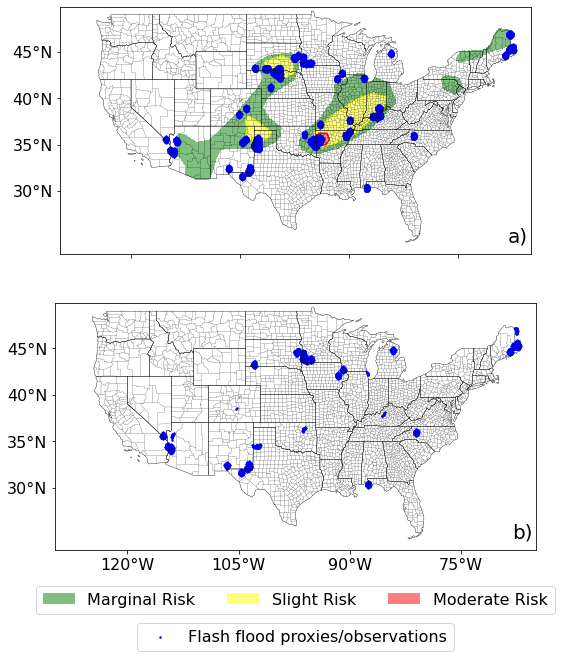

In [126]:
plot_EROs(ERO_netcdf)

### FIG 8: Plot ERO risk categories by county

In [42]:
#create bin size (don't do this manually next time!)
bins_list=[0,5,10,50,100,200]
bins_dict={'bins':bins_list}

evenly_spaced_interval = np.linspace(0, 1, len(bins_list))
LegendElement=[]
#choose color scheme
colors = [cm.plasma_r(x) for x in evenly_spaced_interval]
#create legend labels that correspond to colors
for i,name in zip(range(len(colors)),bins_list):
    if i==0:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(name)))
    else:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(str(bins_list[i-1]+1)+" - "+str(name))))

200 0
86 0
21 0
8 0


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

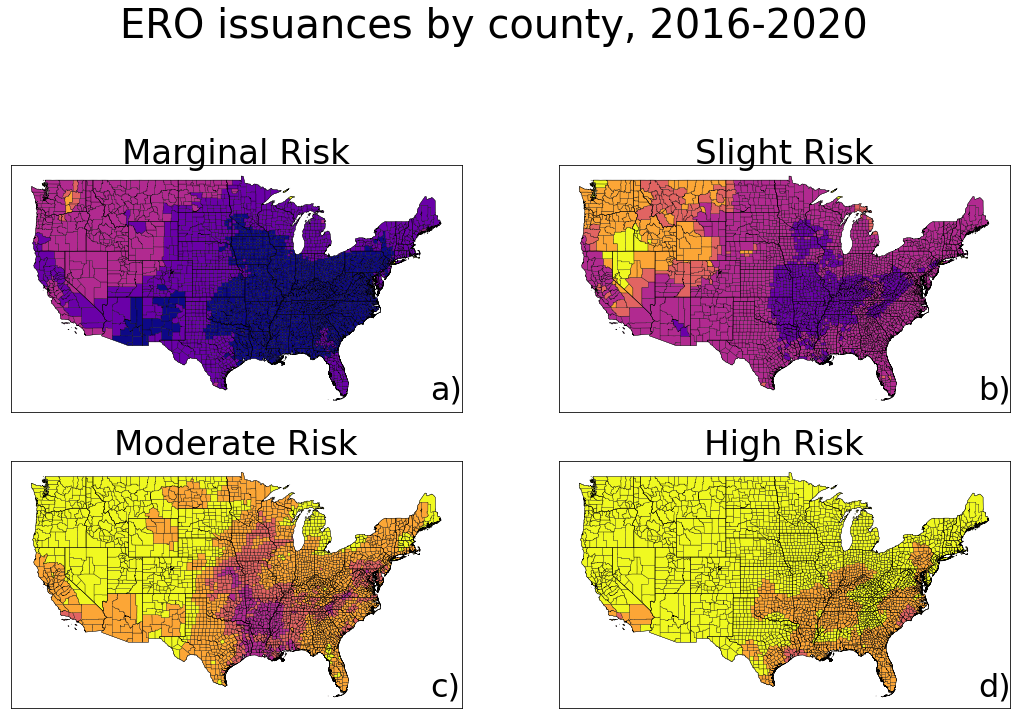

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,10),sharey=True,sharex=True)
  
for risk_level,ax,label in zip(risk_levels_dict,axes.flat,['a)', 'b)', 'c)', 'd)']):


    #set title, set ticks, change ticks to lat/lon
    ax.set_title(risk_levels_dict[risk_level])
    ax.set_xticks(x_meters)
    ax.set_xticklabels(y_latlon_str)
    ax.set_yticks(y_meters)
    ax.set_yticklabels(x_latlon_str)   


    #read file
    ero_counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_Risk_Categories/'+risk_level+'/'+risk_level+'.shp')
   
    #get max min for legend (yes this is lazy but i'm very tired)
    print(max(ero_counties[ero_counties.columns[8]]),min(ero_counties[ero_counties.columns[8]]))
    
    #plot by category
    if risk_level=='marginal':
        ero_counties.plot(ero_counties.columns[8],ax=ax,edgecolor="black",
                   linewidth=0.3,cmap=ListedColormap(colors),
                 scheme='UserDefined',
                classification_kwds=bins_dict)
    elif risk_level=='slight':
        ero_counties.plot(ero_counties.columns[8],ax=ax,edgecolor="black",
                   linewidth=0.3,cmap=ListedColormap(colors[0:5]),
                 scheme='UserDefined',
                classification_kwds=bins_dict) 
    elif risk_level=='moderate':
        ero_counties.plot(ero_counties.columns[8],ax=ax,edgecolor="black",
                   linewidth=0.3,cmap=ListedColormap(colors[0:4]),
                 scheme='UserDefined',
                classification_kwds=bins_dict) 
    elif risk_level=='high':
        ero_counties.plot(ero_counties.columns[8],ax=ax,edgecolor="black",
                   linewidth=0.3,cmap=ListedColormap(colors[0:3]),
                 scheme='UserDefined',
                classification_kwds=bins_dict) 
        
    #add state outlines
    states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=2)
    
    ax.text(0.93, 0.15, label, transform=ax.transAxes,
      fontsize=32, va='top')
#title    
fig.suptitle('ERO issuances by county, 2016-2020',fontsize=40,y=1.1)
#legend + location
#lgd= fig.legend(handles = LegendElement,bbox_to_anchor=[1,0.5], loc='lower left',title="Number of EROs")
lgd= plt.colorbar(cax=colors)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

### FIG 9: Plot damages per Stormdata flood report

In [72]:
#overwrite risk_levels_dict (why? lazy again)
risk_levels_dict={'marginal':'Marginal Risk',
                       'slight':'Slight Risk',
                       'moderate':'Moderate Risk',
                       'high':'High Risk'}

risk_levels_dict_2={'marginal':0.0500000007450580,
                    'slight': 0.100000001490116,
                     'moderate':0.200000002980232,
                    'high':0.5}
    
# choose bins (plz write script for this next time)
bins_list=[100,10000,100000,1000000,1500000]
bins_dict={'bins':bins_list}

evenly_spaced_interval = np.linspace(0, 1, len(bins_list))
LegendElement=[]
colors = [cm.YlOrRd(x) for x in evenly_spaced_interval]
for i,name in zip(range(len(colors)),bins_list):
    if name==bins_list[0]:
        LegendElement.append(mpatches.Patch(color=colors[i],label="<"+str(name)))
    elif name==bins_list[1]:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1])+" - "+str(int(name))))
    else:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(int(bins_list[i-1]))+" - "+str(int(name))))


In [73]:
risk_cat=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_marginal_fixed/StormData_marginal_fixed.shp')
risk_cat=risk_cat.to_crs(3857)

/apps/geopython/1.0.1/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


0.013280212483399735 29216.467463479417


/apps/geopython/1.0.1/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


0.08291873963515754 96517.41293532339


/apps/geopython/1.0.1/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


0.205761316872428 617283.9506172839


/apps/geopython/1.0.1/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


0.5319148936170213 1063829.7872340425


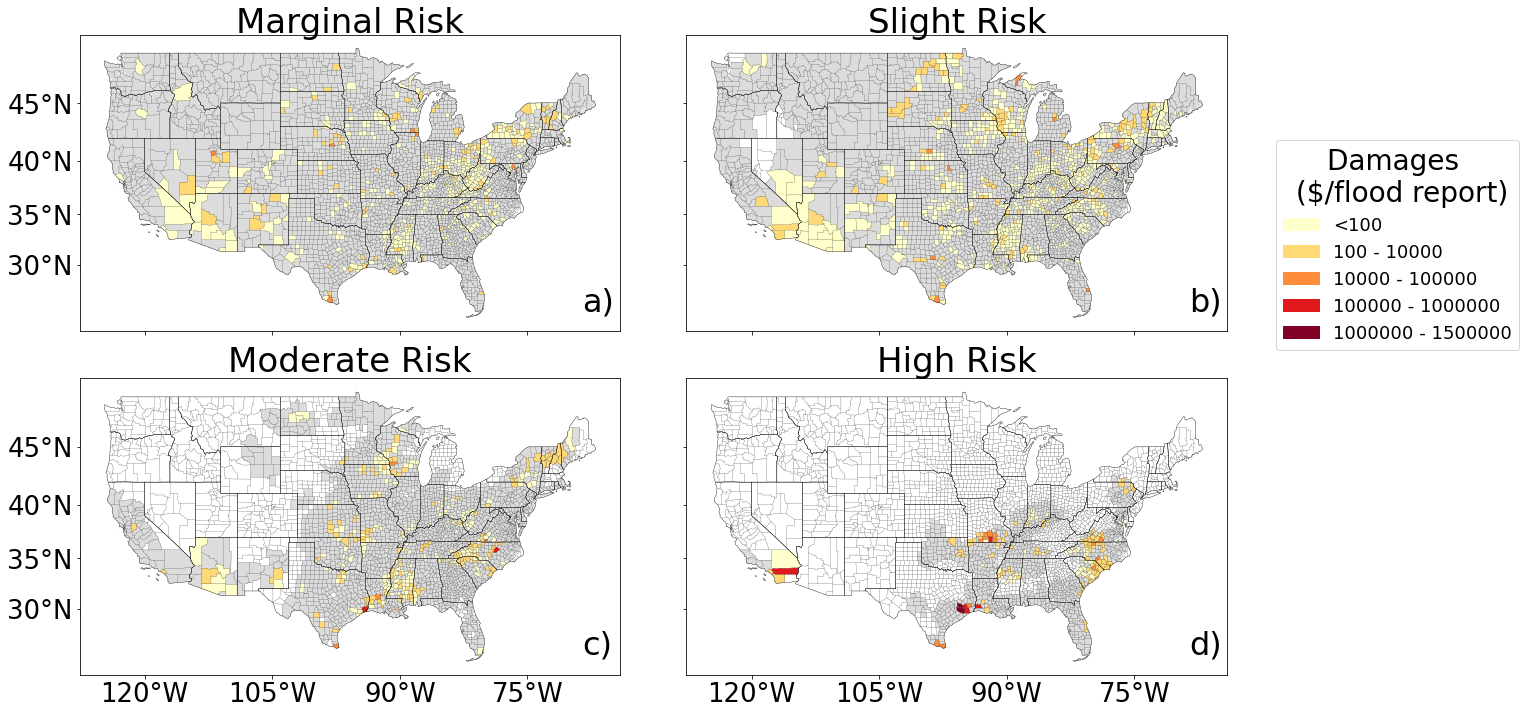

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,10),sharey=True,sharex=True)

for risk_level,risk_level_2,ax,label in zip(risk_levels_dict,risk_levels_dict_2,axes.flat,subplot_labels):


    #set title, set ticks, change ticks to lat/lon
    ax.set_title(risk_levels_dict[risk_level])
    ax.set_xticks(x_meters)
    ax.set_xticklabels(y_latlon_str)
    ax.set_yticks(y_meters)
    ax.set_yticklabels(x_latlon_str)    

    #read file
    cat_df=risk_cat[risk_cat['category']==risk_levels_dict_2[risk_level_2]]
    cat_df['damages_per_FR']=cat_df['property_d']/len(cat_df)
#     damaged_counties=damaged_counties[~damaged_counties['property_d'].isna()]
#     damaged_counties=gpd.GeoDataFrame(damaged_counties)


        
    if risk_level=='high':
        cat_df.plot('damages_per_FR',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True,#legend_kwds={'bbox_to_anchor':(1.45,1),'title':'property damages ($)'},
                             scheme='UserDefined',classification_kwds=bins_dict)
        print(min(cat_df['damages_per_FR']),max(cat_df['damages_per_FR']))
    
    elif risk_level =='moderate':
        cat_df.plot('damages_per_FR',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors[0:4]),zorder=2,#legend=True
                             scheme='UserDefined',classification_kwds=bins_dict)
        print(min(cat_df['damages_per_FR']),max(cat_df['damages_per_FR']))
    
    
    elif risk_level=='slight':
        cat_df.plot('damages_per_FR',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors[0:3]),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        print(min(cat_df['damages_per_FR']),max(cat_df['damages_per_FR']))
        
    elif risk_level=='marginal':
        cat_df.plot('damages_per_FR',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors[0:3]),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        print(min(cat_df['damages_per_FR']),max(cat_df['damages_per_FR']))        
        
    counties.plot(ax=ax,color='none',edgecolor='black',linewidth=0.1,zorder=2)
    states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=3)
    
    ax.text(0.93, 0.15, label, transform=ax.transAxes,
      fontsize=32, va='top')

    #map counties with EROs but no damages
    ero_counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_Risk_Categories/'+risk_level+'/'+risk_level+'.shp')
    ero_counties_0=ero_counties[ero_counties[ero_counties.columns[8]]>0]
    ero_counties_0.plot(ax=ax,color='gainsboro')
    
#     unique_geoid=damaged_counties['GEOID']
#     county_pop_counties=county_pop_csv[county_pop_csv['GEOID'].isin(unique_geoid)][['POPESTIMATE2019','GEOID']]
#     damaged_counties=damaged_counties.merge(county_pop_counties,on="GEOID",how='left')
#     #damaged_counties=damaged_counties.merge(counties_rfc,on="GEOID",how='left')
#     print(damaged_counties['property_d'].sum()/damaged_counties['POPESTIMATE2019'].sum(),damaged_counties['POPESTIMATE2019'].sum())
    
l=fig.legend(handles = LegendElement,fontsize=18,bbox_to_anchor=[1,0.5], loc='lower left',
           title='Damages \n ($/flood report)') 
plt.setp(l.get_title(), multialignment='center')

fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.savefig(r'/blue/emullens/meirahwilliamson/figures/damages_cat_per.png', dpi=300,bbox_inches="tight")

### FIG 2: Plot missed ff proxies/obs

In [129]:
bins_list=[0,2,5,15,40,75]


bins_dict={'bins':bins_list}

evenly_spaced_interval = np.linspace(0, 1, len(bins_list))
LegendElement=[]
colors = [cm.YlGnBu(x) for x in evenly_spaced_interval]
for i,name in zip(range(len(colors)),bins_list):
    if name==bins_list[0]:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i])))
    elif name==bins_list[1]:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1]+1)+" - "+str(int(name))))
    else:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(int(bins_list[i-1]))+" - "+str(int(name))))


In [130]:
risk_levels_dict={'mam':'Spring',
                      'jja':'Summer',
                      'son':'Fall',
                      'djf':'Winter'}

50.0
71.0
49.0
40.0


/apps/geopython/1.0.1/lib/python3.7/site-packages/ipykernel/__main__.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


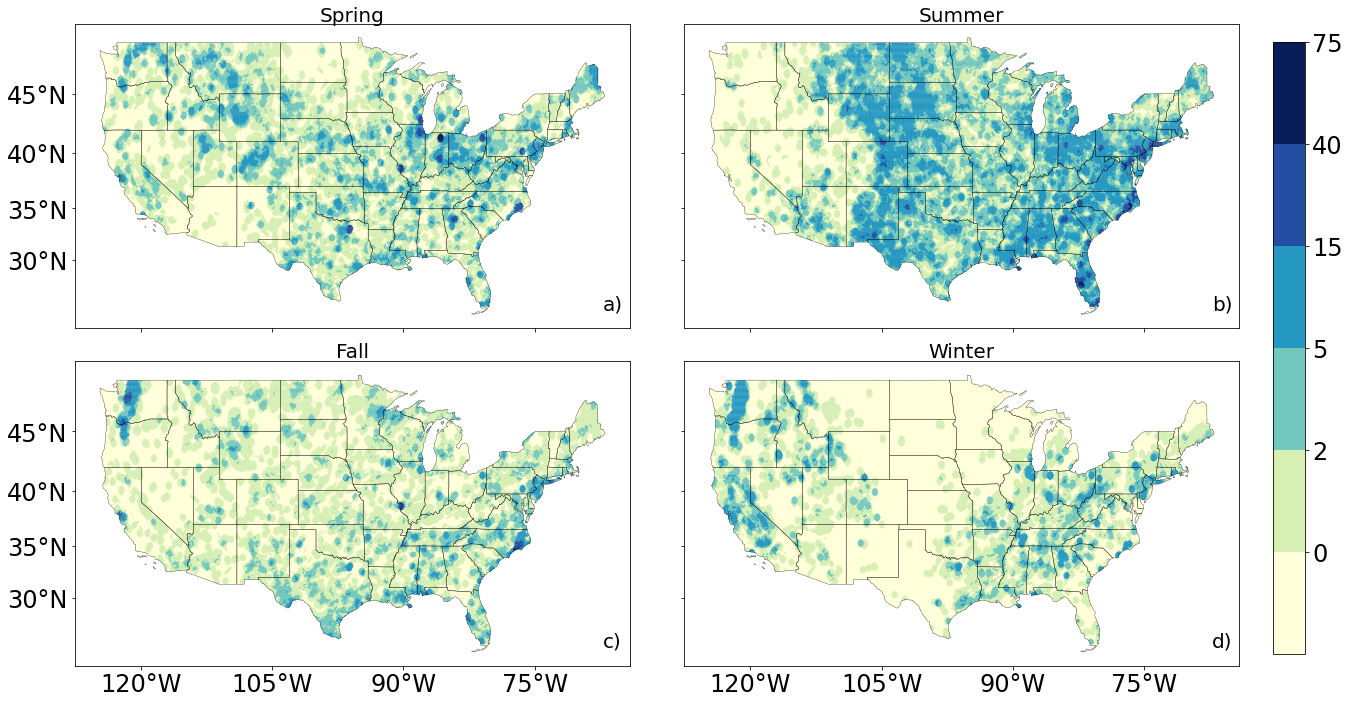

In [131]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,10),sharey=True,sharex=True)

for risk_level,ax,label in zip(risk_levels_dict,axes.flat,subplot_labels):


    #set title, set ticks, change ticks to lat/lon
    ax.set_title(risk_levels_dict[risk_level])
    ax.set_xticks(x_meters)
    ax.set_xticklabels(y_latlon_str)
    ax.set_yticks(y_meters)
    ax.set_yticklabels(x_latlon_str)    

    #read file
    damaged_counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/missed_UFVS/'+risk_level+'_missed_ufvs/'+risk_level+'_missed_ufvs.shp')
    
    #river_join=gpd.sjoin(river,damaged_counties,how='left')
    #state_join=gpd.sjoin(states,damaged_counties,how='left')
    #join_group=river_join.groupby('BASIN_ID').agg({'sum':'sum', 'geometry':'first','RFC_NAME':'first'}).reset_index()
    #join_group=state_join.groupby('STATEFP').agg({'sum':'sum', 'geometry':'first','ALAND':'first'}).reset_index()
    #EROs=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_Risk_Categories/'+risk_level+'/'+risk_level+'.shp')
    #join_group['sum_per_area']=join_group['sum']/join_group['ALAND']*1000000000
    #join_group=gpd.GeoDataFrame(join_group)
    #print(max(join_group['sum_per_area']),min(join_group['sum_per_area']))

    
#     damaged_counties['damages_per_FR']=damaged_counties['property_d']/ damaged_counties['count']
#     damaged_counties=damaged_counties[~damaged_counties['property_d'].isna()]
#     damaged_counties=gpd.GeoDataFrame(damaged_counties)


        
    if risk_level=='mam':
        damaged_counties.plot('sum',ax=ax,edgecolor="none",markersize=2
                               ,cmap=ListedColormap(colors),zorder=2,alpha=1,#legend=True,#legend_kwds={'bbox_to_anchor':(1.45,1),'title':'property damages ($)'},
                              scheme='UserDefined',classification_kwds=bins_dict)
    elif risk_level =='jja':
        damaged_counties.plot('sum',ax=ax,edgecolor="none",markersize=2,
                              cmap=ListedColormap(colors),zorder=2,alpha=1,#legend=True
                             scheme='UserDefined',classification_kwds=bins_dict)
    
    
    elif risk_level=='son':
        damaged_counties.plot('sum',ax=ax,edgecolor="none",markersize=2,
                              cmap=ListedColormap(colors),zorder=2,alpha=1,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        
    elif risk_level=='djf':
        damaged_counties.plot('sum',ax=ax,edgecolor="none",markersize=2,
                              cmap=ListedColormap(colors[:4]),zorder=2,alpha=1,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)


    ax.text(0.95, 0.11, label, transform=ax.transAxes,
          fontsize=20, va='top')
    
    print(max(damaged_counties['sum']))

    states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=3)

cax= fig.add_axes([1,0.075,0.025,0.85])
N= 6
cmap = plt.get_cmap('YlGnBu',N)
norm = mpl.colors.BoundaryNorm([-1,0,2,5,15,40,75], ncolors= N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=bins_list, cax=cax)

fig.tight_layout()#rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(top=0.95)

In [132]:
fig.savefig(r'/blue/emullens/meirahwilliamson/figures/Fig2_missed_UFVS.png', dpi=300,bbox_inches="tight")

### FIG 5: pie chart, missed damages per season by cause 

In [6]:
#doesn't matter which missed_StormData we use -- this one just has an extra column for RFCs
missed_StormData=gpd.read_file(r'/blue/emullens/meirahwilliamson/missed_StormData/missed_individual_RFC/missed_individual_RFC.shp')

In [7]:
#see what keys you need for pie chart
for season in ['djf','mam','jja','son']:
    season_cause=missed_StormData[missed_StormData['season']==season].groupby('flood_caus').count()
    print(season,'\n',season_cause['GEOID'],'\n')

djf 
 flood_caus
Dam / Levee Break     1
Heavy Rain           34
Ice Jam               5
Name: GEOID, dtype: int64 

mam 
 flood_caus
Dam / Levee Break           5
Heavy Rain                168
Heavy Rain / Snow Melt      6
Ice Jam                     2
Name: GEOID, dtype: int64 

jja 
 flood_caus
Dam / Levee Break           1
Heavy Rain                471
Heavy Rain / Burn Area      3
Name: GEOID, dtype: int64 

son 
 flood_caus
Heavy Rain                      114
Heavy Rain / Burn Area            3
Heavy Rain / Tropical System      2
Name: GEOID, dtype: int64 



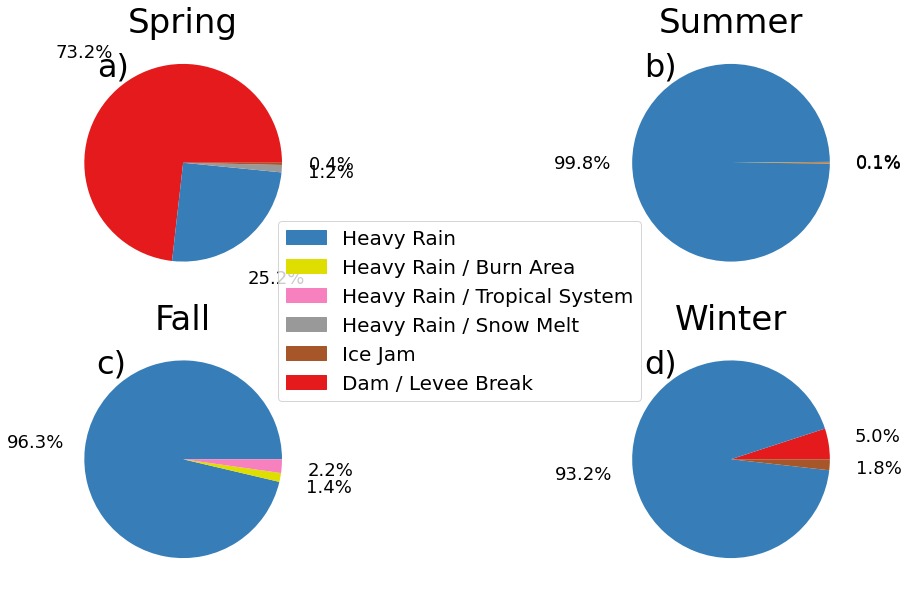

In [12]:
#read in missed stormdata
missed_StormData=gpd.read_file(r'/blue/emullens/meirahwilliamson/missed_StormData/missed_individual_RFC/missed_individual_RFC.shp')

season_dict={'mam':'Spring',
                      'jja':'Summer',
                      'son':'Fall',
                      'djf':'Winter'}


fig,axes=plt.subplots(nrows=2, ncols=2,figsize=(18,10)) 

#choose color cycle
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

#this was al done manually for some reason (see above cell)
for season,ax,label in zip(season_dict,axes.flat,['a)', 'b)', 'c)', 'd)']):
    
    if season=='djf':
        colours = {'Dam / Levee Break': CB_color_cycle[7],
                   'Heavy Rain': CB_color_cycle[0],
                  'Ice Jam':CB_color_cycle[4]
                  }
    if season=='mam':
        colours = {
               'Heavy Rain': CB_color_cycle[0],
               'Heavy Rain / Snow Melt': CB_color_cycle[6],
                  'Ice Jam':CB_color_cycle[4],
            'Dam / Levee Break': CB_color_cycle[7]
                  }       
    if season=='jja':
        colours = {'Dam / Levee Break': CB_color_cycle[7],
               'Heavy Rain': CB_color_cycle[0],
               'Heavy Rain / Burn Area': CB_color_cycle[8]
               }
    if season=='son':
        colours = {'Heavy Rain': CB_color_cycle[0],
               'Heavy Rain / Burn Area': CB_color_cycle[8],
               'Heavy Rain / Tropical System': CB_color_cycle[3]
                  }
    
    season_gdf=missed_StormData[(missed_StormData['season']==season)#&(missed_StormData['flood_caus']!='Dam / Levee Break')
                                &~(missed_StormData['episode_na'].str.contains("Harvey|harvey"))].groupby('flood_caus').sum().reset_index()
    labels_n=season_gdf['flood_caus']

    ax.pie(season_gdf['property_d'],colors=[colours[key] for key in list(labels_n)], autopct='%.1f%%',
           pctdistance=1.5,textprops={'fontsize': 18})
    ax.set_title(season_dict[season] )
    #plt.tight_layout()
    ax.text(0.95, 0.11, label, transform=ax.transAxes,
          fontsize=20, va='top')

    
hr = mpatches.Patch(color=CB_color_cycle[0], label='Heavy Rain')
hrba = mpatches.Patch(color=CB_color_cycle[8], label='Heavy Rain / Burn Area')
hrts = mpatches.Patch(color=CB_color_cycle[3], label='Heavy Rain / Tropical System')
hrsm = mpatches.Patch(color=CB_color_cycle[6], label='Heavy Rain / Snow Melt')
ij = mpatches.Patch(color=CB_color_cycle[4], label='Ice Jam')
dl = mpatches.Patch(color=CB_color_cycle[7], label='Dam / Levee Break')


plt.legend(handles=[hr, hrba, hrts, hrsm, ij, #dl
                   ], loc='center',bbox_to_anchor=[-0.6, 1.1])

#fig.savefig(r'/blue/emullens/meirahwilliamson/figures/damage_attribution_pie.png', dpi=300)


### FIG 7: pie chart, damages by ERO categories

In [47]:
StormData_v2=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_shapefile_noharvey_riskcat/StormData_nh_rc.shp')

In [50]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import netCDF4
import cartopy
from pyproj import CRS, Proj, transform, Transformer
import numpy as np
import mapclassify
import pysal
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

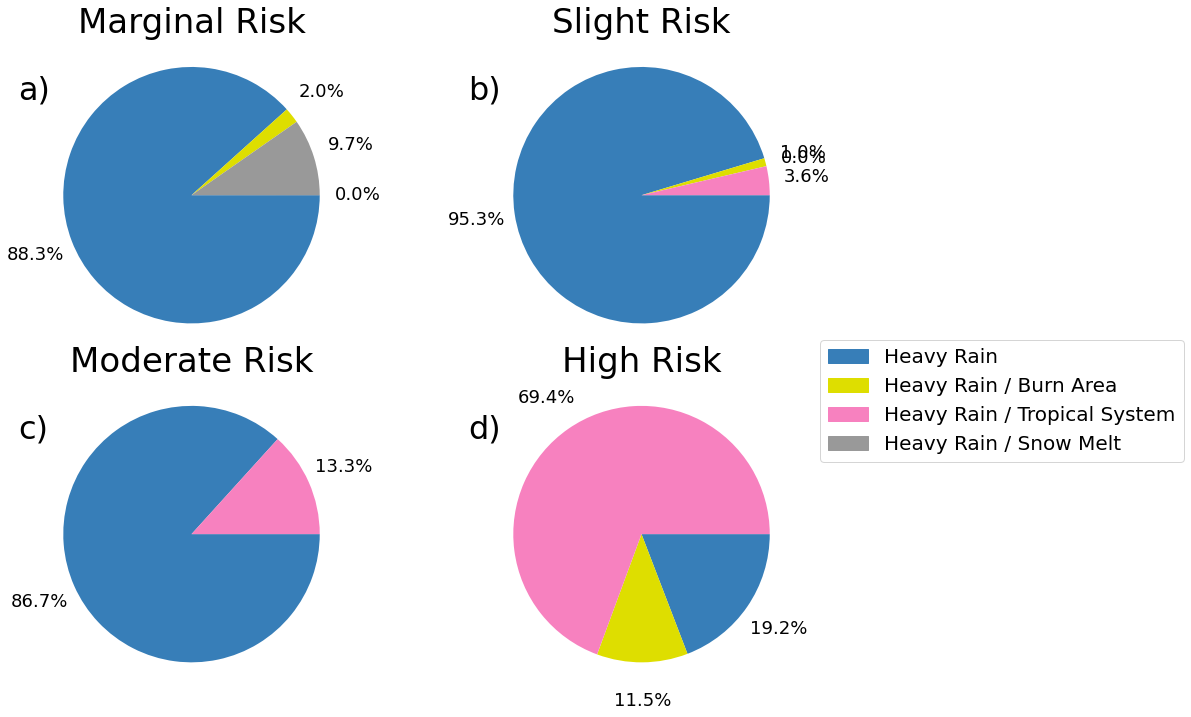

In [15]:
risk_levels_dict={'marginal':'Marginal Risk',
                      'slight':'Slight Risk',
                      'moderate':'Moderate Risk',
                      'high':'High Risk'}

risk_levels_dict_2={'marginal':0.0500000007450580,
                    'slight': 0.100000001490116,
                     'moderate':0.200000002980232,
                    'high':0.5}
                    
fig,axes=plt.subplots(nrows=2, ncols=2,figsize=(18,10)) 

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

for risk_level,ax,risk_level_2,label in zip(risk_levels_dict,axes.flat,risk_levels_dict_2,subplot_labels):
    
    risk_gdf=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_marginal_fixed/StormData_marginal_fixed.shp')
    risk_gdf=risk_gdf[risk_gdf['flood_caus']!='Dam / Levee Break']
    
    if risk_level=='marginal':
        colours = {#'Dam / Levee Break': CB_color_cycle[7],
                   'Heavy Rain': CB_color_cycle[0],
                   'Heavy Rain / Burn Area': CB_color_cycle[8],
                   'Heavy Rain / Snow Melt': CB_color_cycle[6],
                   'Heavy Rain / Tropical System': CB_color_cycle[3],
                  'Ice Jam':CB_color_cycle[4]
                  }

    if risk_level=='slight':
        colours = {
               #'Dam / Levee Break': CB_color_cycle[7],
                   'Heavy Rain': CB_color_cycle[0],
                   'Heavy Rain / Burn Area': CB_color_cycle[8],
                   'Heavy Rain / Snow Melt': CB_color_cycle[6],
                   'Heavy Rain / Tropical System': CB_color_cycle[3]}       
    if risk_level=='moderate':
        colours = {
                   'Heavy Rain': CB_color_cycle[0],
                   'Heavy Rain / Tropical System': CB_color_cycle[3],
            #'Dam / Levee Break': CB_color_cycle[7]
               }
    if risk_level=='high':
        colours = {
                   'Heavy Rain': CB_color_cycle[0],
                   'Heavy Rain / Burn Area': CB_color_cycle[8],
                   
                   'Heavy Rain / Tropical System': CB_color_cycle[3]
                  
                  }
            
    risk_gdf_group=risk_gdf[risk_gdf['category']==risk_levels_dict_2[risk_level_2]]
    risk_gdf_group=risk_gdf_group.groupby('flood_caus').sum().reset_index()
    labels=risk_gdf_group['flood_caus']
    ax.pie(risk_gdf_group['property_d'],colors=[colours[key] for key in labels], autopct='%.1f%%',
           pctdistance=1.3,textprops={'fontsize': 18}, radius=1.2,counterclock=False)
#     if risk_level=='marginal':
#         ax.legend(labels=labels,loc='center',bbox_to_anchor=[-0.96, 0])

    ax.text(-0.15, 0.95, label, transform=ax.transAxes,
      fontsize=32, va='top')
    
    ax.set_title(risk_levels_dict[risk_level],y=1.1)

    
hr = mpatches.Patch(color=CB_color_cycle[0], label='Heavy Rain')
hrba = mpatches.Patch(color=CB_color_cycle[8], label='Heavy Rain / Burn Area')
hrts = mpatches.Patch(color=CB_color_cycle[3], label='Heavy Rain / Tropical System')
hrsm = mpatches.Patch(color=CB_color_cycle[6], label='Heavy Rain / Snow Melt')
#ij = mpatches.Patch(color=CB_color_cycle[4], label='Ice Jam')
#dl = mpatches.Patch(color=CB_color_cycle[7], label='Dam / Levee Break')

plt.legend(handles=[hr, hrba, hrts, hrsm, #dl
                   ], loc='center',bbox_to_anchor=[1.85, 1])

plt.tight_layout()


fig.savefig(r'/blue/emullens/meirahwilliamson/figures/damage_attribution_risks.png')


### FIG 4: number of days w missed damages

In [80]:
bins_list=[0,1,6,12,18]

bins_dict={'bins':bins_list}

risk_levels_dict={'mam':'Spring',
                      'jja':'Summer',
                      'son':'Fall',
                      'djf':'Winter'}

evenly_spaced_interval = np.linspace(0, 1, len(bins_list))
LegendElement=[]
colors = [cm.YlOrRd(x) for x in evenly_spaced_interval]
for i,name in zip(range(len(colors)),bins_list):
    if name==bins_list[0]:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(name)))
    elif name==bins_list[1]:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str((name))))
    else:
        LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1]+1)+" - "+str((name))))


4.0 0.0
18.0 0.0
10.0 0.0
6.0 0.0


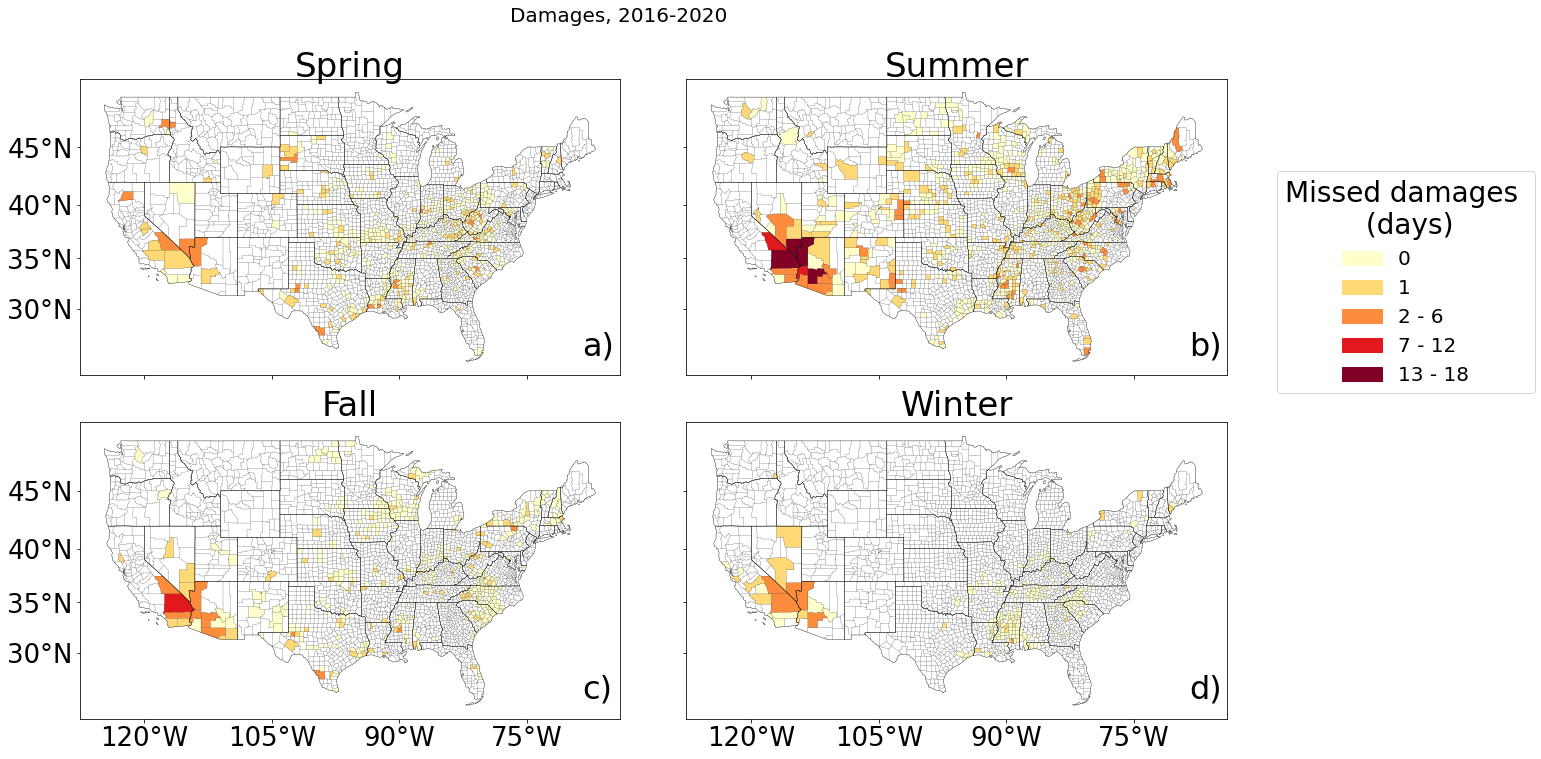

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,10),sharey=True,sharex=True)

for risk_level,ax,label in zip(risk_levels_dict,axes.flat,['a)', 'b)', 'c)', 'd)']):


    #set title, set ticks, change ticks to lat/lon
    ax.set_title(risk_levels_dict[risk_level])
    ax.set_xticks(x_meters)
    ax.set_xticklabels(y_latlon_str)
    ax.set_yticks(y_meters)
    ax.set_yticklabels(x_latlon_str)    

    #read file
    damaged_counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/missed_StormData/missed_damaged_total/'+ risk_level+ '/'+risk_level+'.shp')
    #print(damaged_counties.head())
    #EROs=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_Risk_Categories/'+risk_level+'/'+risk_level+'.shp')

    #damaged_counties_0=damaged_counties[damaged_counties['count']>0]
#     damaged_counties['damages_per_FR']=damaged_counties['property_d']/ damaged_counties['count']
#     damaged_counties=damaged_counties[~damaged_counties['property_d'].isna()]
#     damaged_counties=gpd.GeoDataFrame(damaged_counties)

    #damaged_counties['state_prop_per_count']=damaged_counties['state_prop']/damaged_counties['count']
        
    if risk_level=='jja':
        damaged_counties.plot('count',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True,#legend_kwds={'bbox_to_anchor':(1.45,1),'title':'property damages ($)'},
                             scheme='UserDefined',classification_kwds=bins_dict)

    elif risk_level =='mam':
        damaged_counties.plot('count',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors[0:3]),zorder=2,#legend=True
                             scheme='UserDefined',classification_kwds=bins_dict)
    
    elif risk_level=='son':
        damaged_counties.plot('count',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors[0:4]),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)

    elif risk_level=='djf':
        damaged_counties.plot('count',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors[0:3]),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)

    counties.plot(ax=ax,color='none',edgecolor='black',linewidth=0.1,zorder=2)
    states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=3)
    
    #print(damaged_counties[damaged_counties['count']>1].count()/damaged_counties[damaged_counties['count']>0].count())
    #print(len(damaged_counties[damaged_counties['count']==1])/len(damaged_counties[damaged_counties['count']>0]))
    print(max(damaged_counties.dropna()['count']),min(damaged_counties.dropna()['count']))
    z=damaged_counties[damaged_counties['property_1']>=0]['property_1']
    
    ax.text(0.93, 0.15, label, transform=ax.transAxes,
      fontsize=32, va='top')

    
    
lgd=fig.legend(handles = LegendElement,bbox_to_anchor=[1,0.5], loc='lower left',title="Missed damages \n (days)") 

# l=fig.legend(handles = LegendElement,fontsize=18,bbox_to_anchor=[0.58, 0.55], loc='center right',
#            title='Missed damages (days)') 
plt.setp(lgd.get_title(), multialignment='center')

fig.tight_layout()#rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(top=0.95)
fig.suptitle('Damages, 2016-2020',fontsize=20,y=1.05)
fig.savefig(r'/blue/emullens/meirahwilliamson/figures/missed_damages_count.png',bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=300)

### FIG 6:

NameError: name 'riv_merge' is not defined

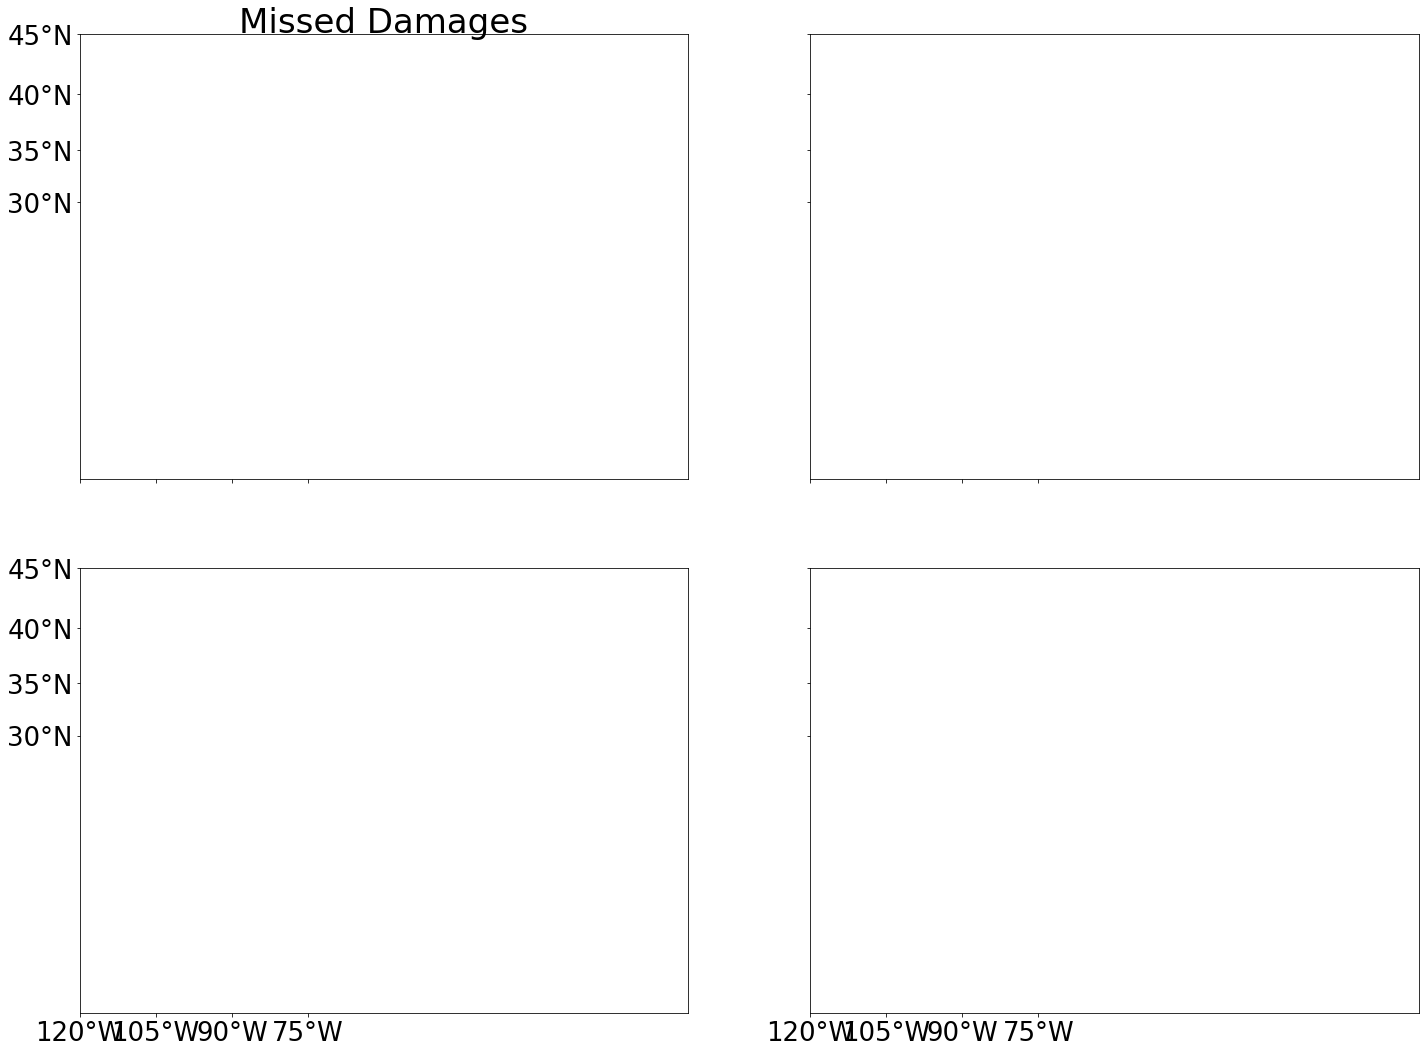

In [82]:
risk_levels_dict={'property_d_x':'Missed Damages',
                      #'property_d_y':'Number of Damaging Missed Flash Flood Events',
                      'damage_per_event':'Missed Damages per Flash Flood Event',
                      'dp_select_counties':'Missed Damages per Capita',
                 'damage_pct_100':'Percent of Missed Damages'}
        
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(24,18),sharey=True,sharex=True)

for risk_level,ax,label in zip(risk_levels_dict,axes.flat,subplot_labels):
    
    if risk_level=='property_d_x':
        bins_list=[1500000,10000000,30000000,60000000,90000000]
#     if risk_level=='property_d_y':
#         bins_list=[20,60,100,140,180]
    if risk_level=='damage_per_event':
        bins_list=[50000,250000,500000,1500000,2000000]
    if risk_level=='dp_select_counties':    
        bins_list=[0.5,2,4,6,8]
    if risk_level=='damage_pct_100':
        bins_list=[0.05,0.1,0.25,0.5,1]

    bins_dict={'bins':bins_list}

    evenly_spaced_interval = np.linspace(0, 1, len(bins_list))
    LegendElement=[]
    colors = [cm.YlGnBu(x) for x in evenly_spaced_interval]
    
    if risk_level=='property_d_x' or risk_level=='damage_per_event':
        for i,name in zip(range(len(colors)),bins_list):
            if name==bins_list[0]:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(name/1000000)))
            else:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1]/1000000)+" - "+str((name/1000000))))
    else:
        for i,name in zip(range(len(colors)),bins_list):
            if name==bins_list[0]:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(name)))
            else:
                LegendElement.append(mpatches.Patch(color=colors[i],label=str(bins_list[i-1])+" - "+str((name))))
        
        
    #fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(18,10),sharey=True,sharex=True)


    #set title, set ticks, change ticks to lat/lon
    ax.set_title(risk_levels_dict[risk_level])
    ax.set_xticks(x_meters)
    ax.set_xticklabels(y_latlon_str)
    ax.set_yticks(y_meters)
    ax.set_yticklabels(x_latlon_str)    

    #read file

# for risk_function(risk_levels_dict)

    if risk_level=='property_d_x':
        riv_merge.plot('property_d_x',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,
                             scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.25, 0],
               title='Damages \n ($1,000,000)')

#     elif risk_level =='property_d_y':
#         riv_merge.plot('property_d_y',ax=ax,edgecolor="none",linewidth=0.1,
#                               cmap=ListedColormap(colors),zorder=2,#legend=True
#                              scheme='UserDefined',classification_kwds=bins_dict)
#         l=ax.legend(handles = LegendElement,fontsize=16, loc='right',bbox_to_anchor=[1.05, 0],
#                title='Damaging Events')

    elif risk_level=='damage_per_event':
        riv_merge.plot('damage_per_event',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.35, 0],
               title='Damages ($1,000,000) \n per event')
        print(max(riv_merge['damage_per_event']),min(riv_merge['damage_per_event']))

    elif risk_level=='dp_select_counties':
        riv_merge.plot('dp_select_counties',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.25, 0],
               title='Damages ($) \n per capita')

    elif risk_level=='damage_pct_100':
        riv_merge.plot('damage_pct_100',ax=ax,edgecolor="none",linewidth=0.1,
                              cmap=ListedColormap(colors),zorder=2,#legend=True
                               scheme='UserDefined',classification_kwds=bins_dict)
        l=ax.legend(handles = LegendElement, loc='right',bbox_to_anchor=[1.35, 0],
               title='Missed damages \n (%)')
    river.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=3)

    states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.1,zorder=2)
    ax.text(0.03, 0.97, label, transform=ax.transAxes,
      fontsize=32, va='top')


#     l=ax.legend(handles = LegendElement,fontsize=16, loc='right',bbox_to_anchor=[1.75, 0],
#                title='Damages ($1,000,000) \n per capita') 
    plt.setp(l.get_title(), multialignment='center')

plt.tight_layout()